In [2]:
import pandas as pd
import pyreadstat

df, meta = pyreadstat.read_dta("HCMST_ver_3.04.dta", encoding="ISO-8859-1")
print(df.head())

   caseid_new  weight1 weight2  ppage  ppagecat  ppagect4  ppeduc  ppeducat  \
0       22526     4265    4265     52         4         3      12         4   
1       23286    16485   16485     28         2         1      13         4   
2       25495    52464     NaN     49         4         3       9         2   
3       26315     4575    4575     31         2         2      11         3   
4       27355    12147     NaN     35         3         2       9         2   

   ppethm  ppgender  ...  w3_mbtiming_year  w3_mbtiming_month  w3_q5  w3_q6  \
0       4         2  ...               NaN                NaN      1      1   
1       1         2  ...               NaN                NaN    NaN    NaN   
2       2         2  ...               NaN                NaN    NaN    NaN   
3       1         1  ...               NaN                NaN    NaN    NaN   
4       1         1  ...               NaN                NaN    NaN    NaN   

   w3_q7  w3_q8  w3_q9  w3_q10  w3_nonmbtiming_yea

In [3]:
df.shape

(4002, 387)

In [4]:
nan_counts = df.isnull().sum()
print(nan_counts)

caseid_new                 0
weight1                    0
weight2                  993
ppage                      0
ppagecat                   0
                        ... 
w3_q8                   3865
w3_q9                   3906
w3_q10                  3915
w3_nonmbtiming_year     3915
w3_nonmbtiming_month    3915
Length: 387, dtype: int64


In [5]:
# Calculate the number of NaN values and their percentage
nan_counts = df.isnull().sum()
nan_percent = (df.isnull().sum() / len(df)) * 100

# Combine into a DataFrame for better readability
nan_summary = pd.DataFrame({
    'nan_count': nan_counts,
    'nan_percent': nan_percent
})

print(nan_summary)

                      nan_count  nan_percent
caseid_new                    0     0.000000
weight1                       0     0.000000
weight2                     993    24.812594
ppage                         0     0.000000
ppagecat                      0     0.000000
...                         ...          ...
w3_q8                      3865    96.576712
w3_q9                      3906    97.601199
w3_q10                     3915    97.826087
w3_nonmbtiming_year        3915    97.826087
w3_nonmbtiming_month       3915    97.826087

[387 rows x 2 columns]


In [6]:
# Формуємо датасет за логікою колонок з даними, які можуть бути корисні для аналізу
df_features = df[['ppagecat', "q24_met_online"]] 
nan_counts = df_features.isnull().sum()
print(nan_counts)

# Calculate the number of NaN values and their percentage
nan_counts = df_features.isnull().sum()
nan_percent = (df_features.isnull().sum() / len(df_features)) * 100

# Combine into a DataFrame for better readability
nan_summary = pd.DataFrame({
    'nan_count': nan_counts,
    'nan_percent': nan_percent
})

print(nan_summary)

ppagecat             0
q24_met_online    1068
dtype: int64
                nan_count  nan_percent
ppagecat                0     0.000000
q24_met_online       1068    26.686657


In [7]:
# Drop the columns that have more than 1000 missing values
columns_to_drop = df_features.columns[((df_features.isnull().sum()/ len(df_features)) * 100) > 50]
df_features_cleaned = df_features.drop(columns=columns_to_drop)

# Print the columns that were dropped
print("Dropped columns and their missing values:")
for col in columns_to_drop:
    print(f"      {col}: {df_features[col].isnull().sum()} missing values")

Dropped columns and their missing values:


In [8]:
# Видаляємо рядки з NaN у target (вони не можуть бути оброблені)
df_features_cleaned = df_features.dropna(subset=["q24_met_online"])
df_features_cleaned.shape

(2934, 2)

In [15]:
df_features_cleaned.dropna(inplace=True)
df_features_cleaned.shape

C:\Users\olyas\AppData\Local\Temp\ipykernel_30520\2127574268.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_cleaned.dropna(inplace=True)


(2934, 2)

In [16]:
# Вибір цільової змінної
target = df_features_cleaned["q24_met_online"]

# Перетворюємо тип object у числовий (може містити текст)
target = pd.to_numeric(target, errors='coerce')

In [17]:
df_features_cleaned = df_features_cleaned.drop(columns=["q24_met_online"])
df_features_cleaned.dtypes

ppagecat    int64
dtype: object

In [18]:
from sklearn.feature_selection import mutual_info_classif

# Обчислюємо MI
mi_scores = mutual_info_classif(df_features_cleaned, target, discrete_features=True)

# Виводимо результати
mi_series = pd.Series(mi_scores, index=df_features_cleaned.columns).sort_values(ascending=False)
print(mi_series)

ppagecat    0.01347
dtype: float64


In [19]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Масштабуємо дані, щоб уникнути великих чисел
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_features_cleaned)

# Обчислюємо chi2 значення
chi_scores, p_values = chi2(df_scaled, target)

# Виводимо результати
chi_series = pd.Series(chi_scores, index=df_features_cleaned.columns).sort_values(ascending=False)
print(chi_series)

ppagecat    8.976516
dtype: float64


In [80]:
from sklearn.decomposition import PCA

# Виконуємо PCA
pca = PCA(n_components=5)  # Вибираємо 5 головних компонент
df_pca = pca.fit_transform(df_features_cleaned)

# Дивимось, скільки інформації пояснюють компоненти
print(pca.explained_variance_ratio_)

[0.62171702 0.14349487 0.05197247 0.0473962  0.03062802]


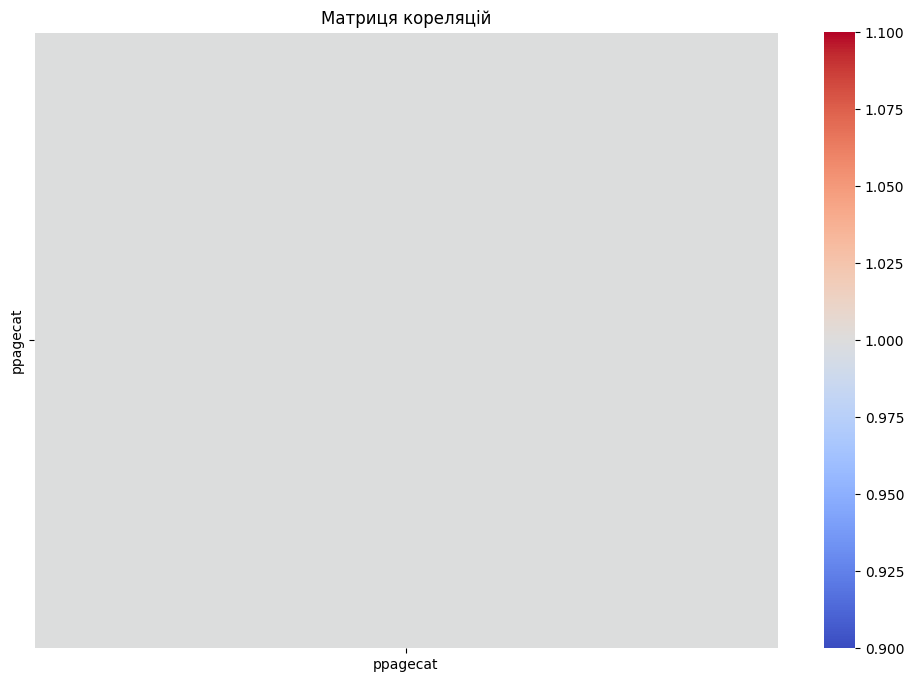

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Будуємо теплову карту кореляцій
plt.figure(figsize=(12, 8))
sns.heatmap(df_features_cleaned.corr(), cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Матриця кореляцій")
plt.show()

In [21]:
# Визначаємо поріг значущості (наприклад, середнє значення)
threshold = mi_series.mean()  

# Фільтруємо значущі ознаки
significant_features = mi_series[mi_series > threshold]
selected_columns = significant_features.index.tolist()

# Відбираємо тільки значущі колонки
df_selected = df_features_cleaned[selected_columns]

# Виводимо результат
print("Обрані значущі ознаки:", selected_columns)
print(df_selected.head())

Обрані значущі ознаки: []
Empty DataFrame
Columns: []
Index: [0, 1, 3, 6, 7]


In [22]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 1️⃣ Використовуємо лише значущі ознаки
X = df_selected.copy()  # df_selected – це відфільтрований датафрейм зі значущими ознаками

# 2️⃣ Масштабуємо дані (стандартизація)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Визначаємо оптимальну кількість кластерів (метод "лікоть")
inertia = []
K_range = range(1, 11)  # Діапазон кластерів для перевірки

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 4️⃣ Візуалізація методу "лікоть"
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Кількість кластерів (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Метод ліктя для вибору k')
plt.show()

# 5️⃣ Виконуємо кластеризацію K-Means++
optimal_k = 4  # Виберіть оптимальне k за графіком ліктя
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 6️⃣ Додаємо кластери до датафрейму
df_selected["Cluster"] = clusters

# 7️⃣ Виводимо кількість об'єктів у кожному кластері
print(df_selected["Cluster"].value_counts())

# 8️⃣ Візуалізація (якщо ознак 2 або 3)
plt.figure(figsize=(8, 5))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label="Центри кластерів")
plt.xlabel("Ознака 1")
plt.ylabel("Ознака 2")
plt.title("K-Means++ кластеризація")
plt.legend()
plt.show()


ValueError: at least one array or dtype is required

In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

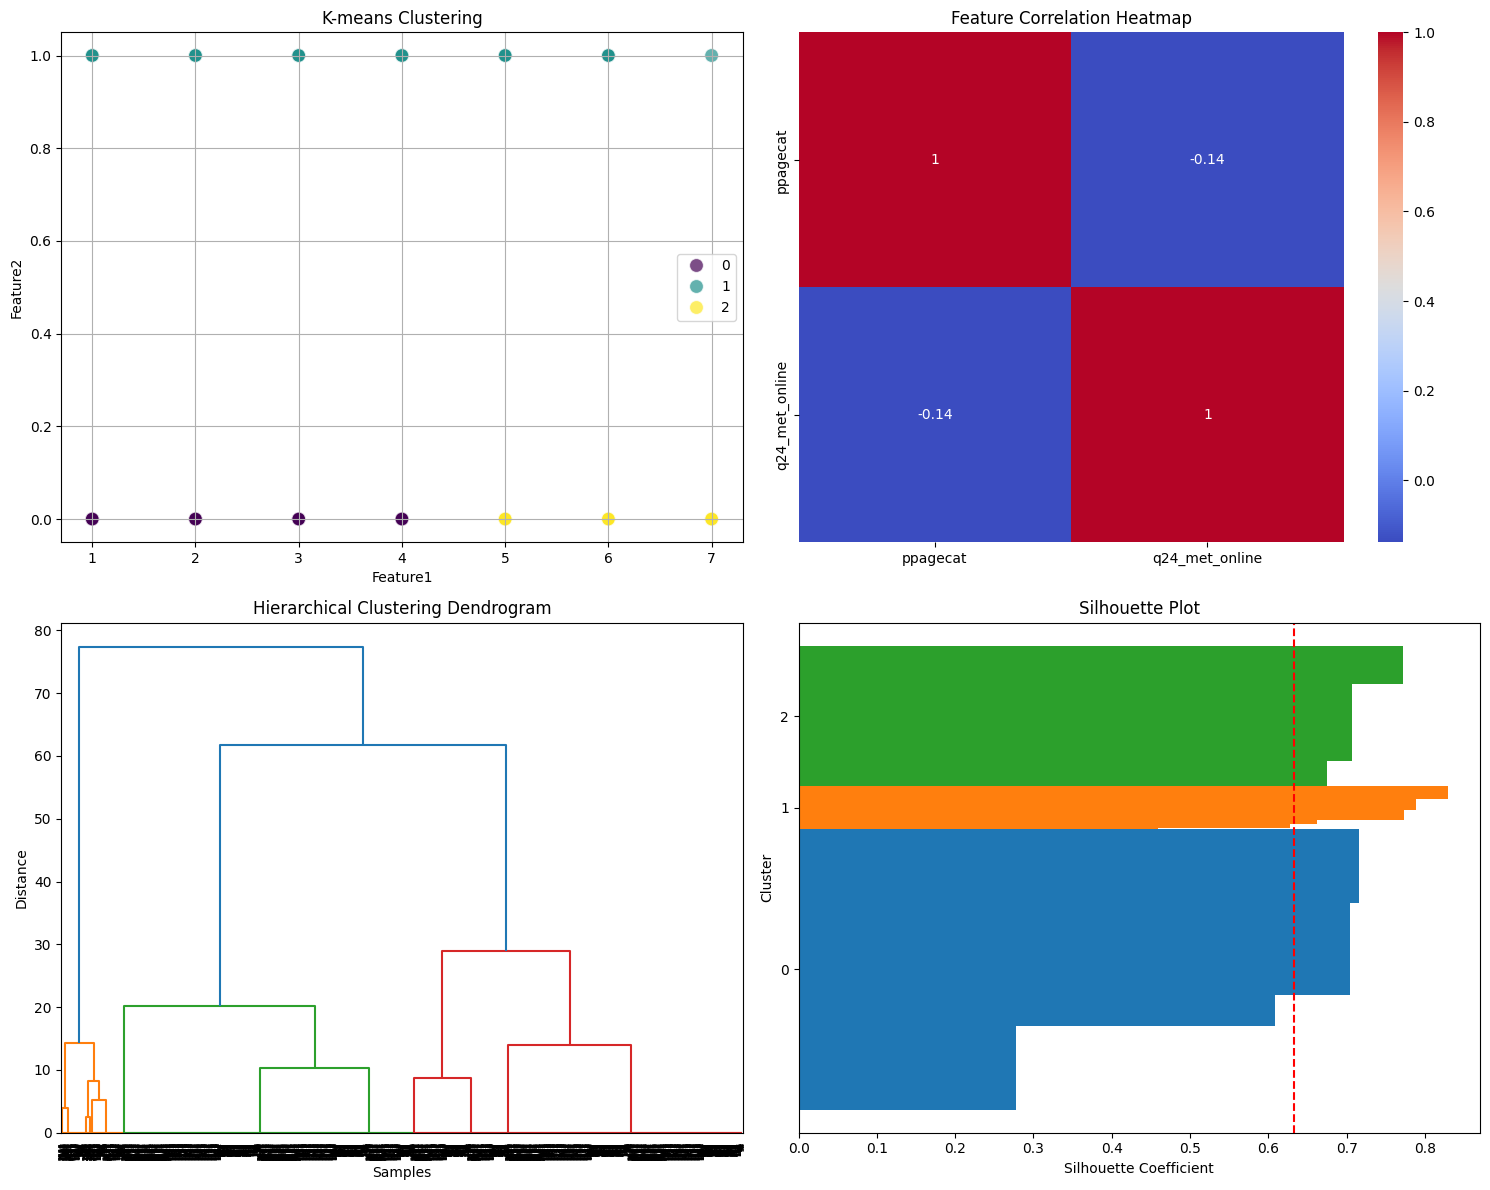

In [10]:
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_features_cleaned)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

# Hierarchical clustering
linked = linkage(scaled_data, 'ward')

# Create subplots for various visualizations
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Scatter plot for K-means clusters
sns.scatterplot(data=df_features_cleaned, x='ppagecat', y='q24_met_online', hue=kmeans_labels, palette='viridis', s=100, alpha=0.7, ax=axs[0, 0])
axs[0, 0].set_title('K-means Clustering')
axs[0, 0].set_xlabel('Feature1')
axs[0, 0].set_ylabel('Feature2')
axs[0, 0].grid(True)

# Heatmap for feature relationships
sns.heatmap(df_features_cleaned.corr(), annot=True, cmap='coolwarm', ax=axs[0, 1])
axs[0, 1].set_title('Feature Correlation Heatmap')

# Dendrogram for hierarchical clustering
dendrogram(linked, ax=axs[1, 0])
axs[1, 0].set_title('Hierarchical Clustering Dendrogram')
axs[1, 0].set_xlabel('Samples')
axs[1, 0].set_ylabel('Distance')

# Silhouette plot for K-means clusters
from sklearn.metrics import silhouette_samples
silhouette_vals = silhouette_samples(scaled_data, kmeans_labels)
y_lower, y_upper = 0, 0
yticks = []
for i, cluster in enumerate(np.unique(kmeans_labels)):
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    axs[1, 1].barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
    yticks.append((y_lower + y_upper) / 2)
    y_lower += len(cluster_silhouette_vals)
axs[1, 1].axvline(silhouette_vals.mean(), color="red", linestyle="--")
axs[1, 1].set_yticks(yticks)
axs[1, 1].set_yticklabels(np.unique(kmeans_labels))
axs[1, 1].set_title('Silhouette Plot')
axs[1, 1].set_xlabel('Silhouette Coefficient')
axs[1, 1].set_ylabel('Cluster')

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig('./clustering_visualizations.png')

# Display the plot
plt.show()